In [1]:
!pip install ctransformers[cuda]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/412.6 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.7/867.7 kB 43.8 MB/s eta 0:00:00


In [2]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from ctransformers import AutoModelForCausalLM
import textwrap
import pandas as pd
from sklearn.metrics import accuracy_score
import json
from tqdm import tqdm

In [3]:
llm = AutoModelForCausalLM.from_pretrained("TheBloke/Mistral-7B-Instruct-v0.1-GGUF", model_file="mistral-7b-instruct-v0.1.Q5_K_M.gguf", model_type="mistral", gpu_layers=50)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

mistral-7b-instruct-v0.1.Q5_K_M.gguf:   0%|          | 0.00/5.13G [00:00<?, ?B/s]

# Evaluation

In [4]:
INITIAL_PROMPT = textwrap.dedent("""
    Welcome to our restaurant order processing service. Before proceeding, please ensure that you spend some time analyzing the customer's order carefully. Customers may provide complex orders with modifications, and it's important to accurately interpret their preferences.
    Please provide the customer's order in a clear and structured manner. We will assist you in converting it to JSON format for easy processing. Follow the instructions below:
    1. Spend time to thoroughly analyze what the customer has ordered. Customers may provide detailed requests, such as modifying their initial order, which requires your attention to ensure their order is processed accurately. Also make sure to include sizes of dishes/drinks in the comments.
    2. Provide the following information for each item:
    - Dish: The name of the dish.
    - Quantity: The number of portions or items ordered.
    - Comment: Any specific instructions or comments related to the order (including size of the drink like: large, medium, small, and other comments like cold, hot, spicy).
    3. Format the order as a JSON object with the following keys:
    {{
        "dish": "Dish Name",
        "quantity": 2,  # Adjust the quantity as needed
        "comment": "Add extra cheese"
    }}
    Now please find the order below inside backtics and return order in the proper JSON format
""")

In [5]:
def create_prompt(order: str, initial_prompt=INITIAL_PROMPT):
    """
    Creates a prompt for the model to process a customer's order.

    Args:
    order (str): The customer's order as a string.

    Returns:
    str: The prompt for the model including the order.
    """
    prompt = textwrap.dedent(f"""
    {initial_prompt}
    ```{order}```
    JSON:
    """)
    return prompt.strip()

In [6]:
file_path = 'dataset3.2.csv'

In [7]:
def preprocess_string(input_string):
    # Remove whitespaces and line breaks
    processed_string = input_string.replace(" ", "").replace("\n", "").replace("'", "\"").lower()
    return processed_string

In [8]:
def extract_values(json_str):
    try:
        json_str = json_str.strip()
        json_str = '[' + json_str + ']'
        data = json.loads(json_str)
        extracted_values = []
        for food_item in data:
          dish = data['dish']
          quantity = data['quantity']
          comment = data['comment']
        extracted_values.append({'dish': dish, 'quantity': quantity, 'comment': comment})
        return extracted_values
    except json.JSONDecodeError:
        print("Error parsing json")
        return '', 0, ''

In [9]:
def process_order(order: dict):
    ordered = []
    for food_item in order:
        dish = food_item["dish"]
        quantity = food_item["quantity"]
        try:
          comment = food_item["comment"]
        except KeyError:
          comment = ""
        confirmed_item = {"dish": dish, "comment": comment, "quantity": quantity}
        ordered.append(confirmed_item)
    return ordered

In [10]:
def json_to_dict(json_str: str):
    try:
        json_str = json_str.strip()
        json_str = '[' + json_str + ']'
        json_dict = json.loads(json_str)
        return json_dict
    except Exception as e:
        raise RuntimeError("Error converting JSON to dictionary: " + str(e)) from e


In [12]:
test_dataset = pd.read_csv(file_path)

expected_labels = test_dataset['Prompt'].tolist()
predicted_labels = [llm(create_prompt(prompt), max_new_tokens=2048, temperature=0.0,
                         top_k=55, top_p=0.9, repetition_penalty=1.2) for prompt in tqdm(test_dataset['User'].tolist(), desc="Generating Predictions")]
total_correct_dishes = 0
total_correct_quantity = 0
total_correct_comment = 0
total_dishes = 0
total_quantity = 0
total_comment = 0
for expected_label, predicted_label in zip(expected_labels, predicted_labels):
  predicted_label = preprocess_string(predicted_label)
  expected_label = preprocess_string(expected_label)
  try:
    predicted_list = process_order(json_to_dict(predicted_label))
  except Exception as e:
    print(f"Error processing order: {e}")
    print("Wrong prediction is: " + predicted_label)
    continue
  expected_list = process_order(json_to_dict(expected_label))

  pred_dish_list = []
  pred_quant_list = []
  pred_comment_list = []
  exp_dish_list = []
  exp_quant_list = []
  exp_comment_list = []
  correct_dishes = 0
  correct_quantity = 0
  correct_comment = 0
  for item in predicted_list:
    pred_dish_list.append(item['dish'])
    pred_quant_list.append(item['quantity'])
    pred_comment_list.append(item['comment'])

  for item in expected_list:
    exp_dish_list.append(item['dish'])
    exp_quant_list.append(item['quantity'])
    exp_comment_list.append(item['comment'])

  for i in range(min(len(predicted_list), len(expected_list))):
    pred_dish = pred_dish_list[i]
    pred_quant = pred_quant_list[i]
    pred_comment = pred_comment_list[i]

    exp_dish = exp_dish_list[i]
    exp_quant = exp_quant_list[i]
    exp_comment = exp_comment_list[i]

    if pred_dish == exp_dish:
        correct_dishes = correct_dishes + 1
    else:
        print(f'Dish Prediction: {pred_dish}, Expected Dish: {exp_dish}')

    if pred_quant == exp_quant:
        correct_quantity = correct_quantity + 1
    else:
        print(f'Quantity Prediction: {pred_quant}, Expected Quantity: {exp_quant}')

    if exp_comment in pred_comment:
        correct_comment = correct_comment + 1
    else:
        print(f'Comment Prediction: {pred_comment}, Expected Comment: {exp_comment}')

  total_correct_dishes = total_correct_dishes + correct_dishes
  total_correct_quantity = total_correct_quantity + correct_quantity
  total_correct_comment = total_correct_comment + correct_comment
  total_dishes = total_dishes + len(exp_dish_list)
  total_quantity = total_quantity + len(exp_quant_list)
  total_comment = total_comment + len(exp_comment_list)

precision_dishes = total_correct_dishes / total_dishes
precision_quantity = total_correct_quantity / total_quantity
precision_comment = total_correct_comment / total_comment
print("Total Predictions made correct")
print(str(total_correct_dishes) + " dishes are correct out of " + str(total_dishes) + ". Percision is " + str(precision_dishes))
print(str(total_correct_quantity) + " quantities are correct out of " + str(total_quantity) + ". Percision is " + str(precision_quantity))
print(str(total_correct_comment) + " comments are correct out of " + str(total_comment) + ". Percision is " + str(precision_comment))

Generating Predictions: 100%|██████████| 134/134 [11:36<00:00,  5.20s/it]

Comment Prediction: addextrachocolatesauce, Expected Comment: m&ms
Quantity Prediction: 2, Expected Quantity: 1
Dish Prediction: chickenmcnuggets, Expected Dish: piecechickenmcnuggets
Comment Prediction: , Expected Comment: sweetandsoursauce
Comment Prediction: , Expected Comment: tartarsauce
Dish Prediction: tartarsauce, Expected Dish: coke
Quantity Prediction: 2, Expected Quantity: 1
Comment Prediction: , Expected Comment: medium
Comment Prediction: addextracheese, Expected Comment: oreocookies
Comment Prediction: , Expected Comment: barbecuesauce
Comment Prediction: , Expected Comment: sweetandsoursauce
Comment Prediction: , Expected Comment: tartarsauce
Dish Prediction: tartarsauce, Expected Dish: coke
Quantity Prediction: 2, Expected Quantity: 1
Comment Prediction: , Expected Comment: medium
Comment Prediction: addextracheese, Expected Comment: oreocookies
Comment Prediction: , Expected Comment: barbecuesauce
Dish Prediction: chickenmcnuggets, Expected Dish: piecechickenmcnuggets


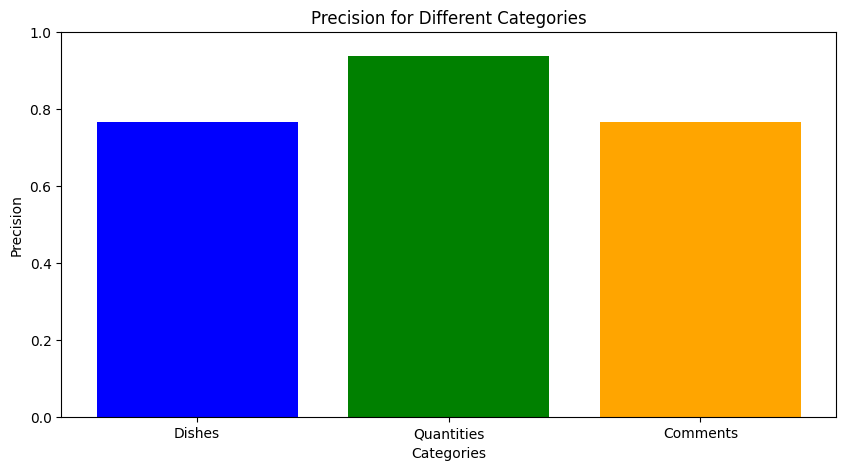

In [13]:
import matplotlib.pyplot as plt
labels = ['Dishes', 'Quantities', 'Comments']
precision_values = [precision_dishes, precision_quantity, precision_comment]

plt.figure(figsize=(10, 5))
plt.bar(labels, precision_values, color=['blue', 'green', 'orange'])
plt.ylim(0, 1)  # Set y-axis limit to show precision values between 0 and 1
plt.xlabel('Categories')
plt.ylabel('Precision')
plt.title('Precision for Different Categories')
plt.show()

In [14]:
# Calculate precision, recall, and F1 score
precision_dishes = total_correct_dishes / total_dishes
recall_dishes = total_correct_dishes / total_correct_dishes
f1_dishes = 2 * (precision_dishes * recall_dishes) / (precision_dishes + recall_dishes)

precision_quantity = total_correct_quantity / total_quantity
recall_quantity = total_correct_quantity / total_correct_quantity
f1_quantity = 2 * (precision_quantity * recall_quantity) / (precision_quantity + recall_quantity)

precision_comment = total_correct_comment / total_comment
recall_comment = total_correct_comment / total_correct_comment
f1_comment = 2 * (precision_comment * recall_comment) / (precision_comment + recall_comment)

# Display F1 score
print("\nF1 Score (Dishes):", f1_dishes)
print("F1 Score (Quantity):", f1_quantity)
print("F1 Score (Comment):", f1_comment)


F1 Score (Dishes): 0.86784140969163
F1 Score (Quantity): 0.9678714859437751
F1 Score (Comment): 0.86784140969163
